In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action = 'ignore')

In [3]:
amzn = pd.read_csv("dataset/AMZN_2006-01-01_to_2018-01-01.csv")
googl = pd.read_csv("dataset/GOOGL_2006-01-01_to_2018-01-01.csv")
ibm = pd.read_csv("dataset/IBM_2006-01-01_to_2018-01-01.csv")
msft = pd.read_csv("dataset/MSFT_2006-01-01_to_2018-01-01.csv")
aapl = pd.read_csv("dataset/AAPL_2006-01-01_to_2018-01-01.csv")
intc = pd.read_csv("dataset/INTC_2006-01-01_to_2018-01-01.csv")
vz = pd.read_csv("dataset/VZ_2006-01-01_to_2018-01-01.csv")
amd = pd.read_csv("dataset/AMD.csv")
nvda = pd.read_csv("dataset/nvidia_all_time_daily_stock_prices.csv")
aaba = pd.read_csv("dataset/AABA_2006-01-01_to_2018-01-01.csv")

In [4]:
amd['Date'] = pd.to_datetime(amd['Date'])
nvda['Date'] = pd.to_datetime(nvda['Date'])
start_date = pd.to_datetime('2006-01-03')
end_date = pd.to_datetime('2017-12-29')
amd_crop = amd[(amd['Date'] >= start_date) & (amd['Date'] <= end_date)]
amd_crop = amd_crop.reset_index(drop=True)
amd_crop['Close'] = amd_crop['Close'].round(2)
nvda_crop = nvda[(nvda['Date'] >= start_date) & (nvda['Date'] <= end_date)]
nvda_crop = nvda_crop.reset_index(drop = True)
nvda_crop['Close'] = nvda_crop['Close'].round(2)

In [5]:
data = pd.concat([amzn[['Date','Close']], googl["Close"], msft["Close"], aapl["Close"], intc['Close'], 
                  nvda_crop['Close'], ibm["Close"], vz['Close'], aaba['Close'], amd_crop['Close']], axis = 1)
data.columns = ['Date', 'amzn', 'googl', 'msft', 'aapl', 'intc','nvda', 'ibm', 'vz', 'aaba', 'amd']
data = data.drop(data.index[-1])
data['Date'] = pd.to_datetime(data['Date'])
cols = list(data)[1:11]

train_data = data[:-100]
test_data = data[-100:]

test_data.head(5)

,Date,amzn,googl,msft,aapl,intc,nvda,ibm,vz,aaba,amd
2919,2017-08-09,982.01,940.08,72.47,161.06,36.59,42.58,142.11,48.60,59.77,13.11
2920,2017-08-10,956.92,923.59,71.41,155.32,36.14,43.03,141.77,48.22,58.03,12.83
2921,2017-08-11,967.99,930.09,72.50,157.48,35.87,41.19,141.84,48.02,57.92,12.12
2922,2017-08-14,983.30,938.93,73.59,159.85,36.34,38.99,141.84,48.06,58.87,12.23
2923,2017-08-15,982.74,938.08,73.22,161.60,36.00,42.10,142.32,48.78,59.99,12.76


In [6]:
train_date = train_data['Date']
test_date = test_data['Date']
train_data = train_data[cols].astype(float)
test_data = test_data[cols].astype(float)
np.shape(train_data)

train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amzn    2919 non-null   float64
 1   googl   2919 non-null   float64
 2   msft    2919 non-null   float64
 3   aapl    2919 non-null   float64
 4   intc    2919 non-null   float64
 5   nvda    2919 non-null   float64
 6   ibm     2919 non-null   float64
 7   vz      2919 non-null   float64
 8   aaba    2919 non-null   float64
 9   amd     2919 non-null   float64
dtypes: float64(10)
memory usage: 228.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 2919 to 3018
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amzn    100 non-null    float64
 1   googl   100 non-null    float64
 2   msft    100 non-null    float64
 3   aapl    100 non-null    float64
 4   intc    100 non-null    float64
 5   nvda    100 non-null    float64
 

In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc = sc.fit(train_data)
scaled_train_data = sc.transform(train_data)

In [24]:
x_train = []
y_train = []

n_future = 1
n_past = 30

for i in range(n_past, len(scaled_train_data) - n_future + 1):
    x_train.append(scaled_train_data[i - n_past:i, 0: train_data.shape[1]])
    y_train.append(scaled_train_data[i + n_future - 1 :i + n_future, 0 : train_data.shape[1]])

x_train, y_train = np.array(x_train), np.array(y_train)

In [44]:
y_train.shape

(2889, 1, 10)

In [45]:
y_train[:,:,0]

array([[-0.95091513],
       [-0.95136144],
       [-0.95119914],
       ...,
       [ 2.8967941 ],
       [ 2.91582328],
       [ 2.90596381]])

In [41]:
x_train.shape

(2889, 30, 10)

In [28]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

In [91]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = True))
model.add(LSTM(32, activation = 'relu', return_sequences = False))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 30, 64)            19200     
                                                                 
 lstm_27 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 31649 (123.63 KB)
Trainable params: 31649 (123.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
history = model.fit(x_train, y_train[:,:,0], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)

Epoch 1/5
82/82 [==============================] - 1s 14ms/step - loss: 0.0320 - val_loss: 0.0319
Epoch 2/5
82/82 [==============================] - 1s 14ms/step - loss: 0.0300 - val_loss: 0.0602
Epoch 3/5
82/82 [==============================] - 1s 15ms/step - loss: 0.0335 - val_loss: 0.0326
Epoch 4/5
82/82 [==============================] - 1s 14ms/step - loss: 0.0322 - val_loss: 0.0970
Epoch 5/5
82/82 [==============================] - 1s 14ms/step - loss: 0.0331 - val_loss: 0.0372


In [102]:
hisotry_amzn = model.fit(x_train, y_train[:,:,0], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)

NameError: name 'hisotry_amzn' is not defined

In [ ]:
history_googl = model.fit(x_train, y_train[:,:,1], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)

In [ ]:
history_msft = model.fit(x_train, y_train[:,:,2], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)

In [ ]:
history_aapl = model.fit(x_train, y_train[:,:,3], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)

In [ ]:
history_intc = model.fit(x_train, y_train[:,:,4], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)

In [ ]:
history_nvda = model.fit(x_train, y_train[:,:,5], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)

In [ ]:
history_ibm = model.fit(x_train, y_train[:,:,6], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)

In [ ]:
history_vz = model.fit(x_train, y_train[:,:,7], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)

In [ ]:
history_aaba = model.fit(x_train, y_train[:,:,8], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)

In [ ]:
history_amd = model.fit(x_train, y_train[:,:,9], epochs = 5, batch_size = 32, validation_split = 0.1, verbose = 1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train_sets = []
y_train_sets = []

for column in df.columns:
    # Extract features (X_train) and target variable (Y_train) for the current column
    x_train = df.drop(column, axis=1)  # Dropping the current column to get features
    y_train = df[column]  # Target variable is the current column
    
    # Append the X_train and Y_train to the respective lists
    X_train_sets.append(X_train)
    Y_train_sets.append(Y_train)

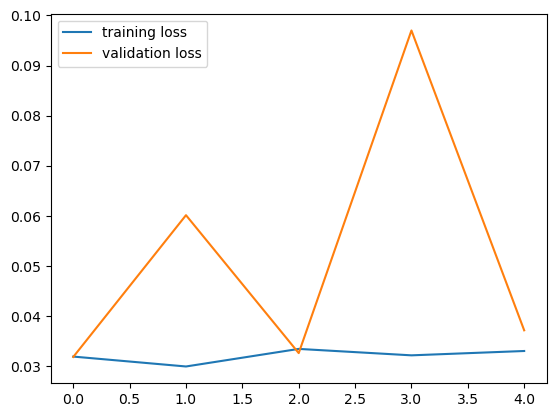

In [78]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

In [84]:
train_predictions = model.predict(x_train).flatten()

91/91 [==============================] - 1s 8ms/step


In [98]:
inverse_y_train = []
for i in range (10):
    inverse_y_train[i] = sc.inverse_transform(y_train[:,:,i])

ValueError: non-broadcastable output operand with shape (2889,1) doesn't match the broadcast shape (2889,10)

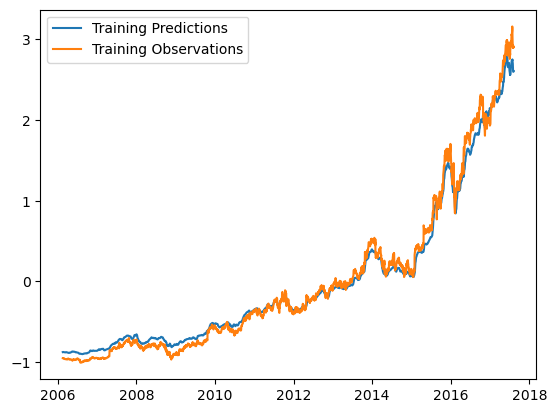

In [90]:
plt.plot(train_date[30:], train_predictions)
plt.plot(train_date[30:], y_train[:,:,0])
plt.legend(['Training Predictions', 'Training Observations'])

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])

In [77]:
predictions = model.predict(x_test)

NameError: name 'x_test' is not defined

In [20]:
def Prediction():
    for num_y in range(0:9):
        history[num_y] = model.fit(x_train, y_train[num_y], epochs = 10, shuffle = False, validation_split = 0.1)

In [21]:
Prediction()

ValueError: Data cardinality is ambiguous:
  x sizes: 2600
  y sizes: 1
Make sure all arrays contain the same number of samples.